#### **Dependencies**

In [19]:
# Importing Required Libraries and Modules
import os
import time
import copy
import random
import pickle
import importlib as lib
from collections import defaultdict
import json

# Data Manipulation and Configuration
import numpy as np
import pandas as pd
import yaml

# PyTorch Utilities
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

# Image Processing Libraries
import cv2
import matplotlib.pyplot as plt
from matplotlib import rc
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda

# Utility Functions
from utils import mnist_dataset
from utils import dataset_getter as dat

# Metrics and Evaluation
from tqdm import tqdm

# Logic Layer Implementation
from difflogic import LogicLayer, GroupSum, PackBitsTensor
import difflogic_cuda

# Configuration Management with Hydra
from hydra import initialize, compose

In [2]:
# Display Available GPU Information
print(f"Detected GPUs: {torch.cuda.device_count()}")

Detected GPUs: 1


#### **Dataset**

/blue/woodard/mkunzlermaldaner/EXPLOGIC/explogic_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Balanced Train Dataset Size: 54210
Balanced Test Dataset Size: 8920


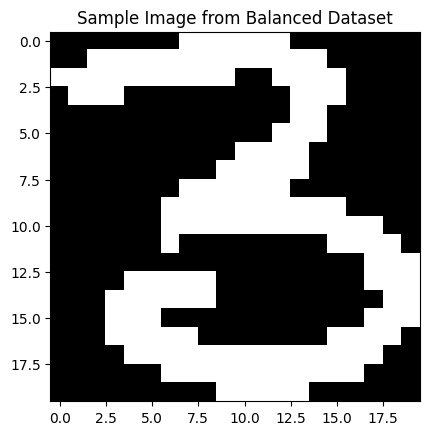

In [3]:
# Dataset and Preprocessing Settings
crop = (20,20)  # Cropping configuration: None removes no border, specify (x,x) for cropping dimensions

# Dataset Selection
# Options: "mnist" or "fashion_mnist"
dataset_name = "mnist"

# Bits Per Pixel (Fixed at 1 for binary data in ExpLogic)
bpp = 1

# Ensuring Reproducibility Across Runs
# Seeds for Random Generators in PyTorch, NumPy, and Python
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# DataLoader Parameters
batch_size = 512
train_loader, test_loader, input_dim, out_dim = dat.get_dataset(
    dataset_name, batch_size=batch_size, data_dir="./data", bpp=bpp, crop=crop
)

# Analyze and Balance Class Distribution in Dataset
train_targets = train_loader.dataset.targets
test_targets = test_loader.dataset.targets

# Class-Wise Sample Count
train_class_counts = [torch.sum(train_targets == i).item() for i in range(10)]
test_class_counts = [torch.sum(test_targets == i).item() for i in range(10)]

# Determine Minimum Samples Per Class for Balanced Dataset
min_samples_train = min(train_class_counts)
min_samples_test = min(test_class_counts)

# Define Function to Trim Datasets for Balance
def balance_dataset(dataset, targets, min_samples):
    indices = []
    for class_label in range(10):
        class_indices = (targets == class_label).nonzero(as_tuple=True)[0]
        indices.extend(class_indices[:min_samples])

    # Shuffle Indices to Randomize the Dataset
    indices = torch.tensor(indices)
    shuffled_indices = indices[torch.randperm(indices.size(0))]
    
    return Subset(dataset, shuffled_indices)

# Apply Balancing to Train and Test Datasets
balanced_train_dataset = balance_dataset(train_loader.dataset, train_targets, min_samples_train)
balanced_test_dataset = balance_dataset(test_loader.dataset, test_targets, min_samples_test)

# Re-Initialize DataLoaders with Balanced Datasets
train_loader_balanced = DataLoader(
    balanced_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True
)
test_loader_balanced = DataLoader(
    balanced_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True
)

# Verify New Dataset Sizes
print(f"Balanced Train Dataset Size: {len(train_loader_balanced.dataset)}")
print(f"Balanced Test Dataset Size: {len(test_loader_balanced.dataset)}")

# Update Loaders and Datasets for Subsequent Use
train_loader = train_loader_balanced
test_loader = test_loader_balanced

# Visualize a Random Image from the Balanced Training Dataset
data_index = random.randint(0, len(train_loader.dataset) - 1)
random_image, _ = train_loader.dataset[data_index]

# Process Image for Display
image_shape = (20, 20) if crop else (28, 28)
processed_image = np.array([
    np.sum([random_image[(i * bpp) + j] * (2 ** (bpp - j + 1)) for j in range(bpp)])
    for i in range(image_shape[0] * image_shape[0])
]).reshape(image_shape)

# Plot the Processed Image
plt.figure()
plt.imshow(processed_image, cmap="gray")
plt.title("Sample Image from Balanced Dataset")
plt.show()

#### **Model Hyperparameters**

Converts csv into yaml config file

In [4]:
# define first input and the name of the file to be saved
if dataset_name == "mnist":
    first_in_dim = 400*bpp
    filename = "config/mnist_config_20x20.yaml"
    df = pd.read_csv("config/mnist_hyperparameters.csv")
elif dataset_name == "fashion_mnist":
    first_in_dim = 784*bpp
    filename = "config/fashion_mnist_config_28x28.yaml"
    df = pd.read_csv("config/fashion_mnist_hyperparameters.csv")

In [5]:
# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_config_20x20.yaml' generated successfully.


#### **Model Function Declarations**

In [6]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        #x = torch.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model', model_cfg=None):
        """
        Saves the model's state dictionary plus all relevant architecture info
        to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model.
            model_cfg (dict): The full dictionary that contains layer config,
                              output_size, tau, learning rate, etc.
        """
        checkpoint_data = {
            'model_state_dict': self.state_dict(),
            'connections': [
                layer.indices 
                for layer in self.logic_layers 
                if isinstance(layer, LogicLayer)
            ],
            # Store the entire config so you can reconstruct everything
            'model_config': {
                'layers_config': model_cfg['layers_config'],
                'output_size': model_cfg['output_size'],
                'tau': model_cfg['tau'],
                'learning_rate': model_cfg.get('learning_rate', None),
            }
        }

        # Now dump that all out to disk
        torch.save(checkpoint_data, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"


    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs.float())

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [7]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### **Training**

In [8]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="Visualizer"):
    cfg = compose(config_name=f"{dataset_name}_config_{image_shape[0]}x{image_shape[0]}")

# training loop for all models
all_models_dict = {}
num_epochs = 1 # just for debugging
file_path = f'trained_models/{dataset_name}_trained_models' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    # initializes DiffLogic model and moves to CUDA if available
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                      output_size=model_cfg['output_size'], 
                      tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

    # wraps the model with DataParallel to distribute workload across GPUs 
    #model = torch.nn.DataParallel(model)
    
    # optimizer and loss criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # early stopping
    early_stopper = EarlyStopper(patience=5)

    print('model', model)

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
        epoch_loss = 0  # to track loss for an epoch            

        for batch_inputs, batch_outputs in loop:
            # move data to the appropriate device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

            # forward pass through the model
            predictions = model(batch_inputs)  
                        
            loss = criterion(predictions, batch_outputs)
            
            # zero gradients, backpropagates, and updates model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # accumulating the loss for the epoch
            epoch_loss += loss.item()

        # caclulating the average loss for the epoch
        epoch_loss /= len(train_loader)
        all_models_dict[model_name]['losses'].append(epoch_loss)
        print(f'Epoch {epoch+1} Loss: {epoch_loss}')

        # checks for early stopping
        if early_stopper.should_stop(epoch_loss):
            print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
            break

    # saving trained model's state
    model.save(file_path, model_name, model_cfg=model_cfg)

print("All models processed.")

training model model_001
LogicLayer(400, 2500, train)
LogicLayer(2500, 2500, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(400, 2500, train)
    (1): LogicLayer(2500, 2500, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/1: 100%|██████████| 105/105 [00:58<00:00,  1.78it/s]


Epoch 1 Loss: 1.8179197958773952
All models processed.


#### **Model Loading**

In [10]:
model_name = 'model_001'
file_path = f'trained_models/{dataset_name}_trained_models/{model_name}.pth' # where to save your trained models
checkpoint = torch.load(file_path, map_location="cuda")  # or "cuda"
loaded_config = checkpoint['model_config']


# Now reconstruct the model using the saved config
model_reconstructed = DiffLogic(
    layers_config=loaded_config['layers_config'],
    output_size=loaded_config['output_size'],
    tau=loaded_config['tau']
)

# Load the state_dict
model_reconstructed.load_state_dict(checkpoint['model_state_dict'])

# If needed, also restore the connections
for idx, layer in enumerate(model_reconstructed.logic_layers):
    if isinstance(layer, LogicLayer):
        layer.indices = checkpoint['connections'][idx]

model_reconstructed.eval()

LogicLayer(400, 2500, train)
LogicLayer(2500, 2500, train)


DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(400, 2500, eval)
    (1): LogicLayer(2500, 2500, eval)
  )
  (group): GroupSum(k=10, tau=10)
)

In [11]:
model_reconstructed.get_accuracy(test_loader)

Running Inference: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]


0.7548253676470589

#### **Get All Connections**

In [18]:
def get_all_connections(model):
    
    # map gate names to indices
    ALL_OPERATIONS = [
        "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
        "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
    ]

    gates_per_layer = []
    
    for layer_idx, layer in enumerate(model.logic_layers):
        layer_connections = []
        
        # for each neuron in the layer
        for neuron_idx in range(layer.weights.size(0)):
            # get the learned gate by taking the argmax of the weights for the neuron
            gate_op_idx = layer.weights[neuron_idx].argmax().item()
            learned_gate = ALL_OPERATIONS[gate_op_idx]

            # get the input connections (indices) for the gate
            input_neuron_a = layer.indices[0][neuron_idx].item()
            input_neuron_b = layer.indices[1][neuron_idx].item()

            # store the gate and connections
            layer_connections.append({
                'neuron_idx': neuron_idx,
                'gate': learned_gate,
                'inputs': (input_neuron_a, input_neuron_b),
            })
        
        gates_per_layer.append(layer_connections)
    
    return gates_per_layer

# retrieve all connections for the model
connections = get_all_connections(model)
connections[0][:5] # example displaying the first 5

[{'neuron_idx': 0, 'gate': 'and', 'inputs': (241, 12)},
 {'neuron_idx': 1, 'gate': 'not_b', 'inputs': (309, 388)},
 {'neuron_idx': 2, 'gate': 'xor', 'inputs': (252, 387)},
 {'neuron_idx': 3, 'gate': 'xor', 'inputs': (253, 57)},
 {'neuron_idx': 4, 'gate': 'not_xor', 'inputs': (263, 190)}]

#### **Convert into Json**

In [22]:
def transform_connections_to_json(connections):
    layer_specs = []
    for layer_idx, layer_conns in enumerate(connections):
        layer_data = []
        for conn in layer_conns:
            # Convert 'inputs' tuple to a list so JSON will handle it
            inputs_list = list(conn["inputs"])  # e.g. (309, 103) -> [309, 103]

            # Build each neuron connection dict
            layer_data.append({
                "neuron_idx": conn["neuron_idx"],
                "gate": conn["gate"],
                "inputs": inputs_list
            })

        # One entry per layer
        layer_specs.append({
            "layer_idx": layer_idx,
            "connections": layer_data
        })

    # Pretty-print JSON string
    return json.dumps(layer_specs, indent=2)

connections_json = transform_connections_to_json(connections)
with open("connections.json", "w") as f:
    f.write(connections_json)

#### **Extracting Model Parameters**

In [28]:
model_name = 'model_001'
file_path = f'trained_models/{dataset_name}_trained_models/{model_name}.pth' # where to save your trained models
checkpoint = torch.load(file_path, map_location="cuda")  # or "cuda"
loaded_config = checkpoint['model_config']

In [29]:
checkpoint

{'model_state_dict': OrderedDict([('logic_layers.0.weights',
               tensor([[-0.0672,  1.9220, -0.9968,  ...,  0.9607, -1.1374,  1.8655],
                       [-1.5337, -0.4288,  0.9440,  ..., -2.2876, -2.4655, -2.5941],
                       [-0.0421,  0.3794, -0.3490,  ...,  0.6202, -0.0378,  0.5037],
                       ...,
                       [-0.2570, -0.9002,  0.1156,  ..., -1.8007, -0.1222, -1.4934],
                       [-1.4102, -0.9311,  1.7573,  ..., -1.8845, -2.0175, -0.1830],
                       [ 1.2210,  0.2777,  0.3703,  ...,  0.9924, -0.8301, -2.5824]],
                      device='cuda:0')),
              ('logic_layers.1.weights',
               tensor([[-0.2500,  0.8593, -1.2279,  ..., -1.4946, -1.0206,  0.0125],
                       [-1.1058,  0.9717, -0.9786,  ...,  1.8457, -2.3426, -1.2387],
                       [-0.7938, -0.1460, -1.4591,  ..., -0.6128,  0.7427,  0.5009],
                       ...,
                       [-0.1099, -0

In [27]:
def extract_model_parameters(state_dict):
    """
    Extracts and prints the weights from a given model state dictionary.

    Args:
        state_dict (OrderedDict): The state dictionary containing model parameters.

    Returns:
        dict: A dictionary where keys are layer names and values are their corresponding tensors.
    """
    parameters = {}

    for name, tensor in state_dict.items():
        parameters[name] = tensor
        print(f"Layer: {name}, Shape: {tensor.shape}, Device: {tensor.device}")
    
    return parameters

extract_model_parameters(checkpoint['model_state_dict'])

Layer: logic_layers.0.weights, Shape: torch.Size([2500, 16]), Device: cuda:0
Layer: logic_layers.1.weights, Shape: torch.Size([2500, 16]), Device: cuda:0


{'logic_layers.0.weights': tensor([[-0.0672,  1.9220, -0.9968,  ...,  0.9607, -1.1374,  1.8655],
         [-1.5337, -0.4288,  0.9440,  ..., -2.2876, -2.4655, -2.5941],
         [-0.0421,  0.3794, -0.3490,  ...,  0.6202, -0.0378,  0.5037],
         ...,
         [-0.2570, -0.9002,  0.1156,  ..., -1.8007, -0.1222, -1.4934],
         [-1.4102, -0.9311,  1.7573,  ..., -1.8845, -2.0175, -0.1830],
         [ 1.2210,  0.2777,  0.3703,  ...,  0.9924, -0.8301, -2.5824]],
        device='cuda:0'),
 'logic_layers.1.weights': tensor([[-0.2500,  0.8593, -1.2279,  ..., -1.4946, -1.0206,  0.0125],
         [-1.1058,  0.9717, -0.9786,  ...,  1.8457, -2.3426, -1.2387],
         [-0.7938, -0.1460, -1.4591,  ..., -0.6128,  0.7427,  0.5009],
         ...,
         [-0.1099, -0.2998, -0.7317,  ..., -1.1587,  2.0011, -1.1070],
         [ 0.9442,  1.2687,  0.6751,  ...,  1.5658,  0.2423,  0.7008],
         [-1.2101,  0.1553, -0.6167,  ...,  0.4056, -0.2175, -0.2946]],
        device='cuda:0')}